In [1]:
# https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/

In [2]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
spacy.load("en_core_web_sm")

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
cd

C:\Users\rands


In [5]:
# Import Dataset
df = pd.read_excel('./_Capstone_Two_NLP/data/_twitter/_dfs_fortheside/df_main.xlsx')
df = df.reset_index()
df = df.drop(columns=['Unnamed: 0','index'])

In [6]:
df.head(3)

,hash,created_at,username,tweet,replies_count,retweets_count,likes_count,reply_to,hashtags,comp,neg,neu,pos,tweet_stemmed,tweet_lemmatized,#_words_tweet,#_hashtags
0,#FightForHongKong,2020-08-28,ginny81025554,Thanks speaking us #fridaysforfreedom #fightfo...,0,1,2,"[{'screen_name': 'benedictrogers', 'name': 'Be...","['fridaysforfreedom', 'fightforhongkong']",0.4404,0.000,0.707,0.293,"['thank', 'speak', 'us', 'fridaysforfreedom', ...","['Thanks', 'speaking', 'u', '#fridaysforfreedo...",5,2
1,#FightForHongKong,2020-08-25,peterhjorth_ddp,How stop China Hong Kong. Read new report Dani...,0,0,0,[],"['dkpol', 'kina', 'hongkongprotest', 'fightfor...",-0.2960,0.071,0.929,0.000,"['stop', 'china', 'hong', 'kong', 'read', 'new...","['How', 'stop', 'China', 'Hong', 'Kong.', 'Rea...",25,13
2,#FightForHongKong,2020-08-24,peterhjorth_ddp,How stop China Hong Kong. Read new report Dani...,0,0,0,[],"['dkpol', 'kina', 'hongkongprotest', 'fightfor...",-0.2960,0.071,0.929,0.000,"['stop', 'china', 'hong', 'kong', 'read', 'new...","['How', 'stop', 'China', 'Hong', 'Kong.', 'Rea...",25,13


In [12]:
# Convert to list
data = df.tweet.values.tolist()

# Remove Emails
#data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
#data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
#data = [re.sub("\'", "", sent) for sent in data]


In [13]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])


[['thanks', 'speaking', 'us']]


In [14]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])


['thank speak', 'how stop china hong kong read new report danish think tank cipo dkpol kina hongkongprot prayforhongkong hongkongprot hongkong hkpolice fivedemand hongkonger']


In [16]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum read occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)


In [17]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")


Sparsicity:  0.14679608635025343 %


In [18]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=20,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes


LatentDirichletAllocation(learning_method='online', n_components=20, n_jobs=-1,
                          random_state=100)


In [19]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())


Log Likelihood:  -11265023.732754724
Perplexity:  1435.8081823584964
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 20,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [20]:
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)


GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [10, 15, 20, 25, 30]})

In [21]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))


Best Model's Params:  {'learning_decay': 0.7, 'n_components': 10}
Best Log Likelihood Score:  -2190377.870945626
Model Perplexity:  778.0569752309382


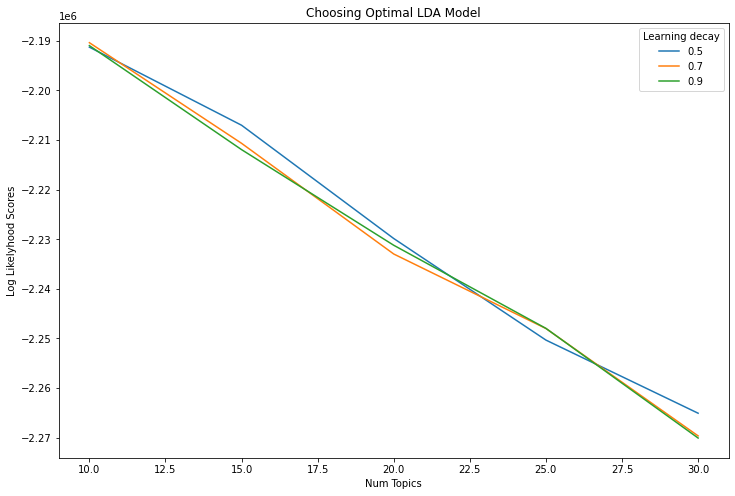

In [22]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [10, 15, 20, 25, 30]

log_likelyhoods_5 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.5]
log_likelyhoods_7 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.7]
log_likelyhoods_9 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()


In [23]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics


,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.700000,9
Doc1,0.200000,0.250000,0.010000,0.010000,0.320000,0.010000,0.010000,0.200000,0.010000,0.010000,4
Doc2,0.230000,0.360000,0.010000,0.010000,0.380000,0.010000,0.010000,0.010000,0.010000,0.010000,4
Doc3,0.310000,0.150000,0.010000,0.010000,0.220000,0.010000,0.010000,0.260000,0.010000,0.010000,0
Doc4,0.230000,0.360000,0.010000,0.010000,0.380000,0.010000,0.010000,0.010000,0.010000,0.010000,4
Doc5,0.260000,0.210000,0.010000,0.010000,0.150000,0.010000,0.010000,0.340000,0.010000,0.010000,7
Doc6,0.130000,0.130000,0.010000,0.010000,0.190000,0.010000,0.010000,0.490000,0.010000,0.010000,7
Doc7,0.110000,0.160000,0.010000,0.010000,0.160000,0.010000,0.010000,0.520000,0.010000,0.010000,7
Doc8,0.020000,0.020000,0.020000,0.320000,0.020000,0.020000,0.020000,0.020000,0.160000,0.410000,9
Doc9,0.010000,0.010000,0.510000,0.390000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,2


In [24]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution


,Topic Num,Num Documents
0,9,25092
1,1,20022
2,3,19055
3,8,18550
4,5,15627
5,0,14913
6,7,14454
7,2,13808
8,4,13200
9,6,8978


In [25]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel


C:\Users\rands\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
3      32.420952   8.115230       1        1  12.850418
1       0.648955  71.707100       2        1  12.117604
8      71.019684   9.971006       3        1  10.806351
4       3.785981  33.185135       4        1  10.162741
5     -42.666500  -9.222070       5        1  10.040455
0      -3.621689 -43.526516       6        1  10.020292
9      -3.632402  -4.171708       7        1   8.859877
2     -36.584400  35.804413       8        1   8.792588
7      44.391380  50.615383       9        1   8.521492
6      40.235809 -31.591665      10        1   7.828183, topic_info=                 Term          Freq         Total Category  logprob  loglift
5435            thank  37620.000000  37620.000000  Default  30.0000  30.0000
2613             hong  28322.000000  28322.000000  Default  29.0000  29.0000
3076             kong  26666.000000  26666.000000  Default  28.0000  28.0000
2176     freehongkong  37217.000000  37217.000000  Default  27.0000  27.0000
2019            fight  12419.000000  12419.000000  Default  26.0000  26.0000
...               ...           ...           ...      ...      ...      ...
2615         hongkong   2484.014062  26483.458575  Topic10  -3.8885   0.1808
3222             life    943.322171   2219.756515  Topic10  -4.8567   1.6917
6102             year   1254.084744   5447.626465  Topic10  -4.5719   1.0787
2175           freehk   1035.345011   4264.351022  Topic10  -4.7636   1.1319
2023  fightforfreedom   1102.896341  14664.133806  Topic10  -4.7004  -0.0400

[733 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
24        4  0.992263        academic
24        6  0.006593        academic
39        1  0.995082  accountability
40        1  0.733280     accountable
40        5  0.263581     accountable
...     ...       ...             ...
6122      8  0.135746           young
6122     10  0.661285           young
6127      2  0.977049         youtube
6127      7  0.013027         youtube
6132      7  0.992556             yue

[1936 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 9, 5, 6, 1, 10, 3, 8, 7])

In [33]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()


,abandon,abc,abduct,abduction,abide,ability,able,abode,abolish,abroad,...,yummy,zara,zealand,zedong,zen,zheng,zipper,zombie,zone,zoom
Topic0,15.644667,0.100003,0.100005,0.100009,4.407032,3.920820,1.051365,0.100020,0.100018,2.083440,...,0.100001,0.100004,8.874700,0.100000,0.100022,0.100014,0.100004,0.100001,4.518801,0.100001
Topic1,19.219519,7.644562,5.071440,4.400332,0.521104,0.100050,103.824945,0.100003,0.100004,20.800338,...,0.100001,0.100009,0.100007,0.100004,0.100027,0.100000,15.723244,17.305714,15.639925,59.413901
Topic2,43.325663,0.100015,0.100008,0.100009,0.100034,17.404339,49.894884,12.082854,0.100020,0.100075,...,0.100001,0.100011,37.636852,0.100001,8.867616,6.541464,0.100005,0.100003,4.151976,0.100014
Topic3,0.100052,0.100016,0.100022,0.806910,13.524733,0.100039,58.455581,0.100008,6.106920,17.919481,...,16.782774,10.818692,0.100010,0.100016,0.100008,0.100003,0.100005,0.100010,3.089196,23.786043
Topic4,13.969711,0.100003,0.100008,0.100017,0.100055,2.253529,14.304997,0.100577,0.100025,19.586330,...,0.100000,0.100003,1.685290,0.100000,3.332290,0.100027,2.476714,0.100027,0.100009,0.100011


In [34]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,hong,kong,freedom,stand,ccp,fight,world,people,country,china,democracy,freehongkong,konger,free,law
Topic 1,freehongkong,year,say,hongkong,know,people,happen,make,think,negative,protest,history,truth,ccp,let
Topic 2,thank,hope,support,sanction,action,ccp,need,stay,senator,world,good,boycottmulan,eye,look,safe
Topic 3,ccp,world,china,democracy,freedom,hongkong,heart,right,amp,regime,free,election,red,human,value
Topic 4,law,freedom,amp,ccp,sanction,security,right,national,hongkong,human,hongkonger,chinazi,soshk,carrielam,evil
Topic 5,police,hkpolicestate,arrest,hkpolice,hongkong,attack,people,negative,citizen,freehongkong,terrorist,brutality,protester,force,use
Topic 6,fight,hongkonger,policebrutality,amp,justice,help,democracy,ccp,face,evil,matter,hker,chinazi,freedom,humanright
Topic 7,hongkong,ccp,world,fightforfreedom,ccpchina,hongkonger,forget,hkpolicestate,boycottchina,china,newwestberlin,standwithhk,freehongkong,pay,joint
Topic 8,freehongkong,china,freetibet,negative,chinese,support,country,hongkong,india,boycottchina,freeuyghur,freetaiwan,people,ccp,taiwan
Topic 9,thank,support,fightforfreedom,hand,hongkonger,folded,stand,hker,freehongkong,hongkong,freeagne,love,negative,speak,freejimmylai


In [35]:
# Define function to predict topic for a given text document.
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization

    # Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))

    # Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)

    # Step 4: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores

# Predict the topic
mytext = ["Some text about polics violence"]
topic, prob_scores = predict_topic(text = mytext)
print(topic)


['freehongkong', 'year', 'say', 'hongkong', 'know', 'people', 'happen', 'make', 'think', 'negative', 'protest', 'history', 'truth', 'ccp', 'let']


In [36]:
from sklearn.cluster import KMeans

In [37]:
# Construct the k-means clusters
clusters = KMeans(n_clusters=8, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))


Component's weights: 
 [[ 0.25  0.36  0.24  0.33  0.23  0.26  0.2   0.26  0.36  0.53]
 [-0.02 -0.32 -0.04 -0.09 -0.08 -0.16 -0.02 -0.1  -0.47  0.79]]
Perc of Variance Explained: 
 [0.01 0.16]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

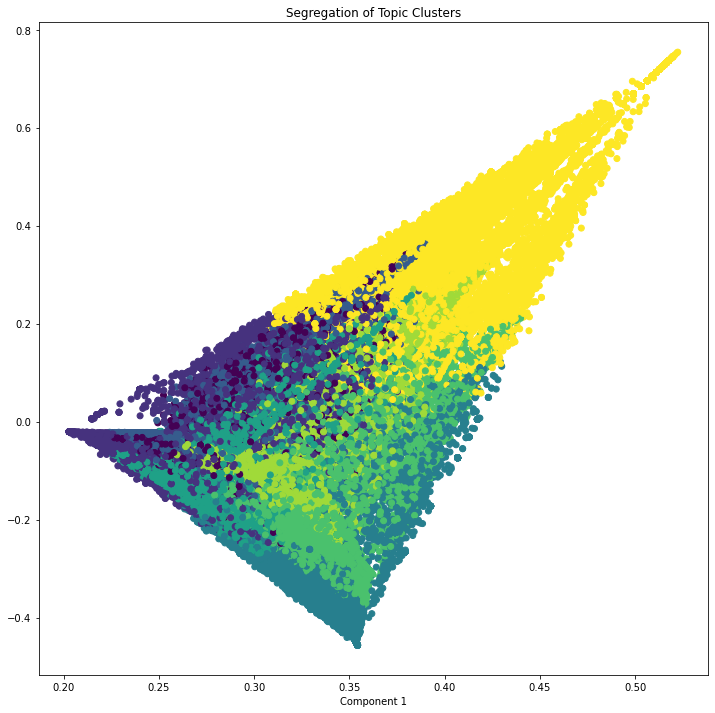

In [38]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )


In [39]:
from sklearn.metrics.pairwise import euclidean_distances

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def similar_documents(text, doc_topic_probs, documents = data, nlp=nlp, top_n=5, verbose=False):
    topic, x  = predict_topic(text)
    dists = euclidean_distances(x.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dists)[:top_n]
    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)


In [40]:
# Get similar documents
mytext = ["Some text about polics violence"]
doc_ids, docs = similar_documents(text=mytext, doc_topic_probs=lda_output, documents = data, top_n=1, verbose=True)
print('\n', docs[0][:500])


Topic KeyWords:  ['freehongkong', 'year', 'say', 'hongkong', 'know', 'people', 'happen', 'make', 'think', 'negative', 'protest', 'history', 'truth', 'ccp', 'let']
Topic Prob Scores of text:  [[0.  0.4 0.  0.  0.  0.3 0.  0.  0.  0. ]]
Most Similar Doc's Probs:   [[0.  0.4 0.  0.  0.  0.3 0.  0.  0.  0. ]]

 It's crazy ridiculous!! #StandWithHongKong
